In [1]:
from inequality_constrained3 import interior_points
from equality_constrained import newton_equality_constrained
from unconstrained import newton_irrestricted, grad_irrestricted
from simplex import LP
import autograd.numpy as np
from autograd import elementwise_grad as egrad
from autograd import jacobian, grad
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.optimize import linprog

## Irrestrito (a)

In [2]:
def generate_instance():
    m = 20
    n = 50
    P = np.diag([1/n for n in range(1,n+1)])
    A = np.random.rand(m, n)
    x_0 = np.random.rand(n)
    b = A.dot(x_0) + 2*np.random.rand(m)
    c = np.ones(n) - 2*np.random.rand(n)
    def f(x):
        l1 = A@P@x
        l2 = P@x
        return c@P@x - np.sum(np.log(b - l1)) - np.sum(np.log(l2))
    return x_0,f

In [3]:
x_0,f = generate_instance()

In [4]:
solver = grad_irrestricted(f,None,x_0=x_0.copy(),autodiff=True)
x,n_iter,sols_grad = solver.solve()

/home/dell/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


In [5]:
solver = newton_irrestricted(f,None,None,x_0.copy())
x, n_iter,sols_nt = solver.solve()

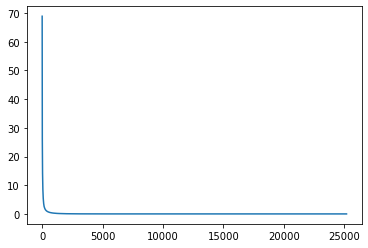

In [7]:
plt.plot([sols_grad[i]-sols_grad[-1] for i in range(len(sols_grad))],label="Grad")

Text(0, 0.5, 'f(x) - p*')

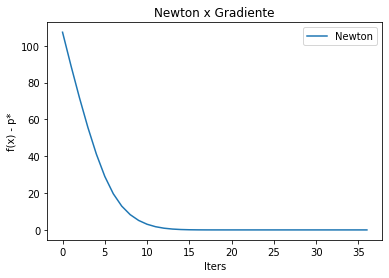

In [8]:
plt.plot([sols_nt[i]-sols_nt[-1] for i in range(len(sols_nt))],label="Newton")
#plt.plot([sols_grad[i]-sols_grad[-1] for i in range(len(sols_grad))],label="Grad")
plt.legend()
plt.title("Newton x Gradiente")
plt.xlabel("Iters")
plt.ylabel("f(x) - p*")

In [ ]:
plt.plot([sols_nt[i]-sols_nt[-1] for i in range(len(sols_nt))],label="Newton")

In [ ]:
f(x)

In [ ]:
data = dict()
data["method"] = []
data["time"] = []
data["iters"] = []
data["instance"] = []
data["opt_val"] = []
data["opt_point"] = []
for i in range(5):
    x_0,f = generate_instance()
    st = time.time()
    solver = grad_irrestricted(f,None,x_0=x_0.copy())
    x,n_iter,sols_grad = solver.solve()
    end = time.time()
    data["method"].append("grad")
    data["time"].append(end - st)
    data["iters"].append(n_iter)
    data["instance"].append(i)
    data["opt_val"].append(sols_grad[-1])
    data["opt_point"].append(x)
    st = time.time()
    solver = newton_irrestricted(f,None,None,x_0.copy())
    x, n_iter,sols_nt = solver.solve()
    end = time.time()
    data["method"].append("newton")
    data["time"].append(end - st)
    data["iters"].append(n_iter)
    data["instance"].append(i)
    data["opt_val"].append(sols_nt[-1])
    data["opt_point"].append(x)

In [ ]:
df = pd.DataFrame.from_dict(data)
df

## Com restrição (b)

In [6]:
def generate_instance_restricted(m,n):
    P = np.diag([1/n for n in range(1,n+1)])
    A = np.random.rand(m, n)
    #x_0 = np.random.rand(n)
    x_0 = np.linalg.pinv(A)@np.ones(m)
    b = A.dot(x_0) + 2*np.random.rand(m)
    c = np.ones(n) - 2*np.random.rand(n)
    l1 = P@x_0
    for i in range(n):
        if c[i] - l1[i] < 0:
            c[i] = l1[i] + np.random.rand()
    def f(x):
        l1 = P@x
        return c@P@x - np.sum(np.log(c - l1))
    return x_0,f,A,b,P,c

In [7]:
x_0,f,A,b,P,c = generate_instance_restricted(50,100)

In [8]:
f(x_0)

77.87638919620933

In [9]:
solver = newton_equality_constrained(f,None,None,A,b,x_0=x_0.copy(),autodiff=True)
x,nu,i,pri,dual,l = solver.solve()

In [10]:
f(x)

-77.71034051226398

In [11]:
x_cp = cp.Variable(len(x_0))
constraints = [A@x_cp == b]
obj = cp.Minimize(c@P@x_cp - cp.sum(cp.log(c - P@x_cp)))
p = cp.Problem(obj,constraints)
p.solve()

-77.71034155982964

Text(0, 0.5, '||r||_2')

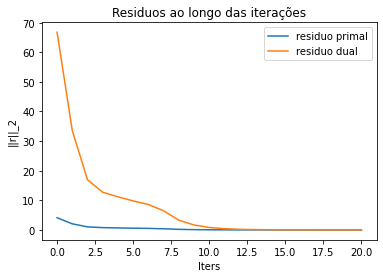

In [12]:
plt.plot(pri,label="residuo primal")
plt.plot(dual,label="residuo dual")
plt.legend()
plt.title("Residuos ao longo das iterações")
plt.xlabel("Iters")
plt.ylabel("||r||_2")

[]

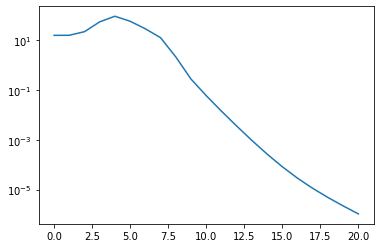

In [13]:
plt.plot(l,label="$\lambda^2/2$")
plt.semilogy()

In [10]:
data = dict()
data["method"] = []
data["time"] = []
data["iters"] = []
data["instance"] = []
data["opt_val"] = []
# data["opt_point"] = []
for i in range(5):
    x_0,f,A,b,P,c = generate_instance_restricted(50,100)
    st = time.time()
    solver = newton_equality_constrained(f,None,None,A,b,x_0=x_0.copy(),autodiff=True)
    x,nu,n_iter,pri,dual,l = solver.solve()
    end = time.time()
    data["method"].append("newton_constrained")
    data["time"].append(end - st)
    data["iters"].append(n_iter)
    data["instance"].append(i)
    data["opt_val"].append(f(x))
#     data["opt_point"].append(x)
    st = time.time()
    x_cp = cp.Variable(len(x_0))
    constraints = [A@x_cp == b]
    obj = cp.Minimize(c@P@x_cp - cp.sum(cp.log(c - P@x_cp)))
    p = cp.Problem(obj,constraints)
    p.solve()
    end = time.time()
    data["method"].append("cvxpy")
    data["time"].append(end - st)
    data["iters"].append(p.solution.attr["num_iters"])
    data["instance"].append(i)
    data["opt_val"].append(p.solution.opt_val)
#     data["opt_point"].append(x)

In [11]:
df = pd.DataFrame.from_dict(data)
df

,method,time,iters,instance,opt_val
0,newton_constrained,0.345463,22,0,-59.601122
1,cvxpy,0.023199,24,0,-59.601127
2,newton_constrained,0.329807,22,1,42.205720
3,cvxpy,0.023740,25,1,42.205704
4,newton_constrained,0.310843,20,2,0.347361
5,cvxpy,0.028546,27,2,0.347321
6,newton_constrained,0.350181,23,3,-63.542002
7,cvxpy,0.022081,22,3,-63.541999
8,newton_constrained,0.362107,22,4,-71.908318
9,cvxpy,0.023043,24,4,-71.908316


## Simplex vs pontos interiores

In [3]:
def to_simplex(A,b,c):
    A_simplex = np.block([ [A,np.zeros(A.shape)],
                           [np.diag(-1*np.ones(A.shape[1])),np.eye(A.shape[1])]
                         ])
    b_simplex = np.hstack([b,np.zeros(A.shape[1])])
    c_simplex = np.hstack([c,np.zeros(A.shape[1])])
    return A_simplex, b_simplex, c_simplex

In [4]:
def gen_LP_instance(m,n):
    A = np.random.rand(m,n)
    x = np.random.rand(n)
    b = A@x
    c = np.random.rand(n)
    return A,b,c

In [15]:
m,n = 50,100
A,b,c = gen_LP_instance(m,n)
def f_0(x):
    return c@x
fs = [f_0]
for i in range(n):
    def f_i(x,i=i):
        return -x[i]
    fs.append(f_i)
# def f_i(x):
#     return np.array
x_0 = np.random.rand(n)
solver = interior_points(fs,A.copy(),b.copy(),x_0.copy())
x,nu,vals,nt_steps,l  = solver.solve()

/home/dell/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


Max infeasibility:  -0.022555591178297196
Begins phase two


In [5]:
c@x

15.04490192059371

In [6]:
# x_cp = cp.Variable(len(x))
# constraints = [A@x_cp == b]
# obj = cp.Minimize(c@x_cp)
# p = cp.Problem(obj,constraints)
# p.solve(verbose=True)
linprog(c,A_eq=A,b_eq=b)

     con: array([-1.88694855e-08, -1.97160936e-08, -2.14065139e-08, -1.92873593e-08,
       -1.96089189e-08, -1.89866647e-08, -1.85328801e-08, -2.43128717e-08,
       -2.06038493e-08, -2.27601689e-08, -1.91157916e-08, -1.82800619e-08,
       -1.99513721e-08, -1.85980724e-08, -1.89420462e-08, -1.80119386e-08,
       -1.92032701e-08, -1.99972661e-08, -1.97362624e-08, -1.86343634e-08,
       -1.99855599e-08, -1.90797849e-08, -1.98609165e-08, -1.85581222e-08,
       -1.85567828e-08, -2.02680823e-08, -1.99441317e-08, -1.97203285e-08,
       -1.71689365e-08, -1.97834531e-08, -1.99113899e-08, -1.90731129e-08,
       -2.08174100e-08, -2.03681232e-08, -1.82101658e-08, -1.93839007e-08,
       -1.88455829e-08, -1.76673822e-08, -1.83178415e-08, -2.02831281e-08,
       -1.77839183e-08, -2.02412878e-08, -1.71466503e-08, -1.99141077e-08,
       -1.96663557e-08, -1.95457055e-08, -1.80868582e-08, -1.76716561e-08,
       -1.92059204e-08, -1.81203710e-08])
     fun: 15.039851824062943
 message: 'Optimiza

In [7]:
A_s,b_s,c_s = to_simplex(A,b,c)
solver = LP(A_s,b_s,c_s)
x,opt_val,simplex_vals = solver.solve()

Não há solução
Encontrou uma base


In [8]:
c_s@x

15.039851790079656

Text(0, 0.5, 'Duality gap')

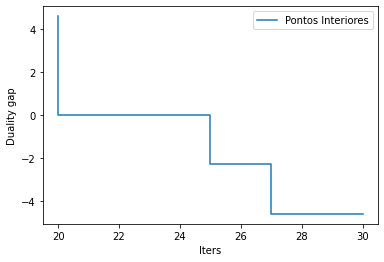

In [17]:
#simplex_ = np.abs([v - simplex_vals[-1] for v in simplex_vals])            
plt.step(steps,np.log(vals),label="Pontos Interiores")
#plt.stairs(values=np.log(simplex_),label="Simplex")
plt.legend()
plt.xlabel("Iters")
plt.ylabel("Duality gap")

Text(0, 0.5, 'Optimality gap')

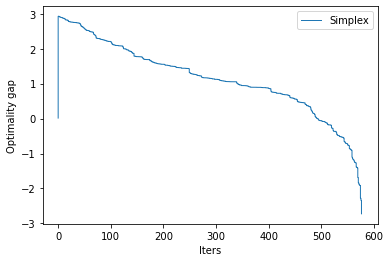

In [10]:
#ip = np.abs([v - vals[-1] for v in vals])
simplex_ = np.abs([v - simplex_vals[-1] for v in simplex_vals])            
#plt.stairs(values=np.log(ip),label="Pontos Interiores")
plt.stairs(values=np.log(simplex_),label="Simplex")
plt.legend()
plt.xlabel("Iters")
plt.ylabel("Optimality gap")

In [54]:
data = dict()
data["method"] = []
data["time"] = []
data["iters"] = []
data["instance"] = []
data["opt_val"] = []
m,n = 50,100
for i in range(5):
    A,b,c = gen_LP_instance(m,n)
    def f_0(x):
        return c@x
    if i == 0:
        fs = [f_0]
        for i in range(n):
            def f_i(x,i=i):
                return -x[i]
            fs.append(f_i)
    else:
        fs[0] = f_0
    x_0 = np.random.rand(n)
    st = time.time()
    solver = interior_points(fs,A.copy(),b.copy(),x_0.copy())
    x,nu,vals,_,_ = solver.solve()
    end = time.time()
    data["method"].append("pontos interiores")
    data["time"].append(end - st)
    data["iters"].append(len(vals))
    data["instance"].append(i)
    data["opt_val"].append(c@x)
    print("----------------------")
    A_s,b_s,c_s = to_simplex(A,b,c)
    st = time.time()
    solver = LP(A_s,b_s,c_s)
    x,opt_val,simplex_vals = solver.solve()
    end = time.time()
    data["method"].append("simplex")
    data["time"].append(end - st)
    data["iters"].append(len(simplex_vals))
    data["instance"].append(i)
    data["opt_val"].append(c_s@x)
#     data["opt_point"].append(x)

/home/dell/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


Max infeasibility:  -0.036616322643236
Begins phase two


KeyboardInterrupt: 

In [33]:
df = pd.DataFrame.from_dict(data)
df

,method,time,iters,instance,opt_val
0,pontos interiores,72.157490,5,99,18.118170
1,simplex,4.759701,615,99,18.113118
2,pontos interiores,67.227067,5,1,16.099161
3,simplex,3.621449,425,1,16.094197
4,pontos interiores,66.842649,5,2,16.213036
5,simplex,3.325775,479,2,16.208056
6,pontos interiores,70.519541,5,3,12.014670
7,simplex,4.502864,584,3,12.009670
8,pontos interiores,67.806587,5,4,14.061911
9,simplex,4.005294,501,4,14.056863


In [6]:
def gen_LP_instance_non_image(m,n):
    A = np.random.rand(m,n)
    x = np.random.rand(n)
    b = A@x
    b += np.random.uniform(-1,1,m)
    c = np.random.rand(n)
    return A,b,c

In [3]:
m = 50
n = 100
# A,b,c = gen_LP_instance_non_image(m,n)
P = A@np.linalg.inv(A.T@A)@A.T
assert (P@b == b).all() == False
def f_0(x):
    return c@x
fs = [f_0]
for i in range(m):
    def f_i(x):
        return A[i,:]@x - b[i]
    fs.append(f_i)

In [8]:
with open('A.npy', 'wb') as f:
    np.save(f,A)
with open('b.npy', 'wb') as f:
    np.save(f,b)

In [2]:
with open('A.npy', 'rb') as f:
    A = np.load(f)
with open('b.npy', 'rb') as f:
    b = np.load(f)

In [4]:
x_0 = np.random.rand(n)
solver = interior_points(fs,A.copy(),b.copy(),x_0.copy(),method_max=False)
x = solver.phase_one_sum()
a = b - A@x
plt.hist(a,20)
plt.ylabel("Number")
plt.xlabel("$b_i - a_i^Tx_{sum}$")
plt.plot()
plt.show()

/home/dell/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


KeyboardInterrupt: 

Max infeasibility:  1.2041212171588023


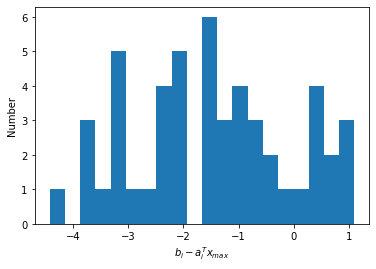

In [8]:
solver = interior_points(fs,A.copy(),b.copy(),x_0.copy())
x = solver.phase_one_max()
a = b - A@x
plt.hist(a,20)
plt.ylabel("Number")
plt.xlabel("$b_i - a_i^Tx_{max}$")
plt.plot()
plt.show()

## Solver vs Interior Points

In [26]:
mu_vals = []
nt_steps = []
gap = []
m,n = 50,100
A,b,c = gen_LP_instance(m,n)
def f_0(x):
    return c@x
fs = [f_0]
for i in range(n):
    def f_i(x,i=i):
        return -x[i]
    fs.append(f_i)
x_0 = np.random.rand(n)
# for i in range(5):
#     mu = np.random.uniform(1.2,200)
#     mu_vals.append(mu)
#     solver = interior_points(fs,A.copy(),b.copy(),x_0.copy())
#     x,nu,vals,steps = solver.solve()
#     nt_steps.append(steps)

In [27]:
for mu in [2,50,100]:
    mu_vals.append(mu)
    solver = interior_points(fs,A.copy(),b.copy(),x_0.copy(),mu=mu)
    x,nu,vals,steps,_ = solver.solve()
    nt_steps.append(steps)
    gap.append(vals)

/home/dell/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


Max infeasibility:  -0.058440436581560506
Begins phase two
Max infeasibility:  -0.058440436581560506
Begins phase two
Max infeasibility:  -0.058440436581560506
Begins phase two


In [37]:
np.allclose(A@x,b)

True

In [38]:
np.all([f(x)<=0 for f in fs[1:]])

True

(18.0, 35.0)

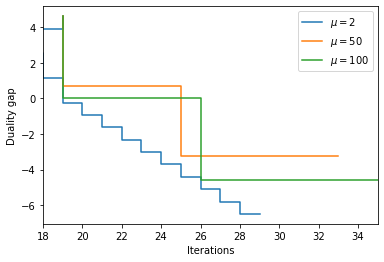

In [30]:
m = 100
for i in range(3):
    plt.step(nt_steps[i],np.log(gap[i]),label=f"$\mu = {mu_vals[i]}$")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Duality gap")
plt.xlim(18,35)

In [55]:
data = dict()
data["method"] = []
data["time"] = []
data["iters"] = []
data["instance"] = []
data["opt_val"] = []
m,n = 50,100
for i in range(5):
    A,b,c = gen_LP_instance(m,n)
    def f_0(x):
        return c@x
    if i == 0:
        fs = [f_0]
        for i in range(n):
            def f_i(x,i=i):
                return -x[i]
            fs.append(f_i)
    else:
        fs[0] = f_0
    x_0 = np.random.rand(n)
    st = time.time()
    solver = interior_points(fs,A.copy(),b.copy(),x_0.copy())
    x,nu,vals,_,_ = solver.solve()
    end = time.time()
    data["method"].append("pontos interiores")
    data["time"].append(end - st)
    data["iters"].append(len(vals))
    data["instance"].append(i)
    data["opt_val"].append(c@x)
    print("----------------------")
    st = time.time()
    x_cp = cp.Variable(len(x_0))
    constraints = [A@x_cp == b,x_cp>=0]
    obj = cp.Minimize(c@x_cp)
    p = cp.Problem(obj,constraints)
    p.solve()
    end = time.time()
    data["method"].append("cvxpy")
    data["time"].append(end - st)
    data["iters"].append(p.solution.attr["num_iters"])
    data["instance"].append(i)
    data["opt_val"].append(p.solution.opt_val)
#     data["opt_point"].append(x)

/home/dell/anaconda3/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


Max infeasibility:  -0.011837915321484815
Begins phase two
----------------------
Max infeasibility:  -0.0032423226584772378
Begins phase two
----------------------
Max infeasibility:  -0.0036361075280370034
Begins phase two
----------------------
Max infeasibility:  -0.006809408526215145
Begins phase two
----------------------
Max infeasibility:  -0.013665540731773618
Begins phase two
----------------------


In [62]:
data["instance"][0] = data["instance"][1] = 0

In [63]:
df = pd.DataFrame.from_dict(data)
df

,method,time,iters,instance,opt_val
0,pontos interiores,66.746768,5,0,13.843384
1,cvxpy,0.016958,12,0,13.838220
2,pontos interiores,67.231335,5,1,15.243167
3,cvxpy,0.017625,10,1,15.238118
4,pontos interiores,71.590695,5,2,17.362022
5,cvxpy,0.022174,11,2,17.356952
6,pontos interiores,72.794597,5,3,15.386620
7,cvxpy,0.016535,10,3,15.381639
8,pontos interiores,68.065300,5,4,15.336378
9,cvxpy,0.015560,10,4,15.331420


In [ ]:
!conda install sympy

In [ ]:
import sympy
from sympy import Symbol, simplify

In [ ]:
s = [Symbol('s_'+str(i+1)) for i in range(2)]
t = Symbol('t')
x = [Symbol('x_'+str(i+1)) for i in range(2)]

lamb = 0
for i in range(2):
    lamb -= sympy.ln(s[i] + x[i]) - t*s[i]
simplify(lamb)

In [ ]:
[lamb.diff(x_i) for x_i in x+[s]]

In [ ]:
[lamb.diff(x_i).diff(y_i) for x_i in [s]+x for y_i in [s]+x]

In [ ]:
x = [Symbol('x_'+str(i+1)) for i in range(2)]
c = [Symbol('c_'+str(i+1)) for i in range(2)]
t = Symbol('t')
lamb = 0
for i in range(2):
    lamb += t*c[i]*x[i]
    lamb -= sympy.ln(x[i])
simplify(lamb)

In [ ]:
[lamb.diff(x_i) for x_i in x]

In [ ]:
[lamb.diff(x_i).diff(y_i) for x_i in x for y_i in x]